<a href="https://colab.research.google.com/github/jaimeh94/ml-zoomcamp/blob/main/04-evaluation/Homework_4_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Homework 4

Use this notebook as a starter

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# %matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [2]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 12:18:45--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv’

CreditScoring.csv   100%[===================>] 178.21K  --.-KB/s    in 0.02s   

2021-10-04 12:18:45 (11.0 MB/s) - ‘CreditScoring.csv’ saved [182489/182489]



## Preparation 

We'll talk about this dataset in more details in week 6. But for now, use the following code to get started

In [3]:
df = pd.read_csv('CreditScoring.csv')
df.columns = df.columns.str.lower()

Some of the features are encoded as numbers. Use the following code to de-code them:

In [4]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

Prepare the numerical variables:

In [5]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

Remove clients with unknown default status

In [6]:
df = df[df.status != 'unk'].reset_index(drop=True)

Create the target variable

In [7]:
df['default'] = (df.status == 'default').astype(int)
del df['status']

## Your code

What are the categorical variables? What are the numerical?

In [48]:
df.seniority

0        9
1       17
2       10
3        0
4        0
        ..
4449     1
4450    22
4451     0
4452     0
4453     5
Name: seniority, Length: 4454, dtype: int64

In [40]:
categorical_features = list(df.select_dtypes(include=object).columns)
numerical_features = list(df.select_dtypes(include=int).columns)
numerical_features = numerical_features[:-1]
print(categorical_features)
print(numerical_features)

['home', 'marital', 'records', 'job']
['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt', 'amount', 'price']


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`

In [52]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [51]:
y_train

array([1229, 1630, 2208, ..., 1490, 1829, 1538])

In [63]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
result = []
for feature in numerical_features:
  fpr, tpr, thresholds = roc_curve(y_train, df_train[feature])
  auc_score = auc(fpr, tpr).round(3)
  if auc_score < 0.5:
      fpr, tpr, thresholds = roc_curve(y_train, -df_train[feature])
      auc_score = auc(fpr, tpr).round(3)  

  result.append([feature,auc_score])

result

[['seniority', 0.709],
 ['time', 0.561],
 ['age', 0.573],
 ['expenses', 0.501],
 ['income', 0.682],
 ['assets', 0.649],
 ['debt', 0.505],
 ['amount', 0.591],
 ['price', 0.504]]

Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

**Answer**: 'seniority'

## Training the model

From now on, use these columns only:

```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [70]:
def train(df_train, y_train, features, C=1.0, max_iter=1000):
    from sklearn.feature_extraction import DictVectorizer
    from sklearn.linear_model import LogisticRegression
    
    dicts = df_train[features].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=max_iter)
    model.fit(X_train, y_train)
    
    return dv, model

def predict(df, dv, model, features):
    from sklearn.feature_extraction import DictVectorizer
    dicts = df[features].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [71]:
features = ['seniority', 'income', 'assets', 'records', 'job', 'home']
dv, model = train(df_train, y_train, features)

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

In [74]:
y_pred = predict(df_val, dv, model, features)
roc_auc_score(y_val, y_pred).round(3)

0.812

**Answer**: AUC=0.812

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

In [79]:
scores = []
thresholds = np.linspace(0,1,100)
for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    
    scores.append([t, tp, tn, fp, fn])

df_scores = pd.DataFrame(scores, columns=["thresholds", "tp", "tn", "fp", "fn"])

df_scores["precision"] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores["recall"] = df_scores.tp / (df_scores.tp + df_scores.fn)

df_scores.head()

,thresholds,tp,tn,fp,fn,precision,recall
0,0.000000,246,0,645,0,0.276094,1.00000
1,0.010101,246,10,635,0,0.279228,1.00000
2,0.020202,244,32,613,2,0.284714,0.99187
3,0.030303,242,53,592,4,0.290168,0.98374
4,0.040404,242,82,563,4,0.300621,0.98374


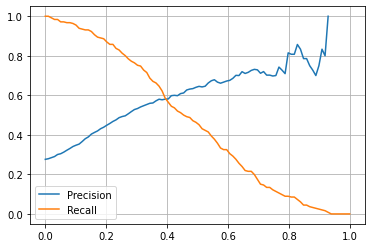

In [82]:
plt.plot(df_scores.thresholds, df_scores['precision'], label='Precision')
plt.plot(df_scores.thresholds, df_scores['recall'], label='Recall')
plt.grid(True)
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

**Answer:** The intercept is 0.4

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [83]:
df_scores["f1_score"] = 2 * (df_scores["precision"] * df_scores["recall"])/(df_scores["precision"] + df_scores["recall"])

In [88]:
df_scores.thresholds[df_scores.f1_score==df_scores.f1_score.max()].round(1)

31    0.3
Name: thresholds, dtype: float64

At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

**Answer**: 0.3

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


In [92]:
from sklearn.model_selection import KFold

scores = []
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

for train_idx, val_idx in kfold.split(df_full_train): 
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    dv, model = train(df_train, df_train.default, features)
    y_pred = predict(df_val, dv, model, features)

    auc = roc_auc_score(df_val.default, y_pred)
    scores.append(auc)

print(' %.3f +- %.3f' % (np.mean(scores), np.std(scores)))

 0.812 +- 0.014


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

**Answer:** 0.14

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [94]:
for C in (0.01, 0.1, 1, 10):
    scores = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    for train_idx, val_idx in kfold.split(df_full_train): 
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        dv, model = train(df_train, df_train.default, features, C=C)
        y_pred = predict(df_val, dv, model, features)

        auc = roc_auc_score(df_val.default, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C

**Answer:** C=1

## Submit the results

Submit your results here: https://forms.gle/e497sR5iB36mM9Cs5

It's possible that your answers won't match exactly. If it's the case, select the closest one.

## Deadline

The deadline for submitting is 04 October 2021, 17:00 CET. After that, the form will be closed.